# 02 — Model Inference & Evaluation

This notebook demonstrates the anomaly detection ensemble end-to-end:
- Loading the trained model via `AnomalyPredictor`
- Single-observation predictions with vote breakdown
- Batch prediction throughput benchmarking
- Decision boundary visualization
- Threshold sensitivity analysis
- Confusion matrix on held-out test data

> **Note:** No running API required — the predictor is imported directly.

In [1]:
import sys
import time
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import joblib
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc
)

# Add project root to path so we can import app/
PROJECT_ROOT = Path("__file__").resolve().parent.parent
sys.path.insert(0, str(PROJECT_ROOT))

from app.predictor import AnomalyPredictor

plt.style.use("dark_background")
COLORS = {
    "normal": "#00d4aa",
    "anomaly": "#ff6b6b",
    "accent": "#a29bfe",
    "neutral": "#74b9ff",
}

print("Imports OK")

Imports OK


## 1. Load Model

In [2]:
MODEL_PATH = PROJECT_ROOT / "model" / "artifacts" / "ensemble_model.joblib"

predictor = AnomalyPredictor(model_path=str(MODEL_PATH), redis_client=None)

assert predictor.is_loaded, "Model not found — run: python model/train.py"

info = predictor.model_info()
print(json.dumps(info, indent=2))

{
  "model_version": "1.0.0",
  "algorithm": "Ensemble (IsolationForest + LOF + Z-score)",
  "n_features": 8,
  "contamination_rate": 0.05,
  "anomaly_threshold": 3.0,
  "training_samples": 8000,
  "f1_score": 0.8626,
  "precision": 0.8426,
  "recall": 0.8835,
  "detectors": [
    "isolation_forest",
    "lof",
    "zscore"
  ]
}


## 2. Single-Observation Predictions

In [3]:
# Craft three representative observations
test_cases = [
    {
        "label": "Nominal reading",
        "features": [0.12, -0.08, 0.31, 0.05, -0.22, 0.18, 0.09, -0.14],
    },
    {
        "label": "Mild outlier",
        "features": [1.8, -1.5, 2.1, 1.7, -1.9, 0.9, 1.6, -1.3],
    },
    {
        "label": "Extreme spike anomaly",
        "features": [8.5, -7.2, 9.1, 0.05, -0.1, 0.2, -8.8, 7.6],
    },
]

for case in test_cases:
    result = predictor.predict(case["features"], observation_id=case["label"])
    flag = "🚨 ANOMALY" if result["is_anomaly"] else "✅ NORMAL"
    votes = result["votes"]
    print(f"\n{case['label']}")
    print(f"  Result     : {flag}")
    print(f"  Confidence : {result['confidence']:.0%}")
    print(f"  IF score   : {result['anomaly_score']:.4f}")
    print(f"  Votes      : IF={votes['isolation_forest']} | LOF={votes['lof']} | Z={votes['zscore']}")
    print(f"  Latency    : {result['inference_ms']:.2f} ms")


Nominal reading
  Result     : ✅ NORMAL
  Confidence : 100%
  IF score   : -0.3498
  Votes      : IF=False | LOF=False | Z=False
  Latency    : 35.22 ms

Mild outlier
  Result     : 🚨 ANOMALY
  Confidence : 67%
  IF score   : -0.5297
  Votes      : IF=True | LOF=True | Z=False
  Latency    : 31.15 ms

Extreme spike anomaly
  Result     : 🚨 ANOMALY
  Confidence : 100%
  IF score   : -0.6779
  Votes      : IF=True | LOF=True | Z=True
  Latency    : 28.63 ms


## 3. Batch Prediction & Throughput

In [4]:
rng = np.random.default_rng(42)

# Generate a realistic mixed batch: 95% normal, 5% anomalous
N = 500
cov = np.eye(8) * 0.8
for i in range(7):
    cov[i, i+1] = cov[i+1, i] = 0.3

X_normal  = rng.multivariate_normal(np.zeros(8), cov, size=int(N * 0.95))
X_anomaly = rng.uniform(-10, 10, size=(int(N * 0.05), 8))
X_batch   = np.vstack([X_normal, X_anomaly])
y_true    = np.array([0] * len(X_normal) + [1] * len(X_anomaly))

# Shuffle
idx = rng.permutation(len(X_batch))
X_batch, y_true = X_batch[idx], y_true[idx]

# Time batch prediction
t0 = time.perf_counter()
results = predictor.predict_batch(X_batch.tolist())
elapsed = time.perf_counter() - t0

y_pred   = np.array([1 if r["is_anomaly"] else 0 for r in results])
scores   = np.array([r["anomaly_score"] for r in results])
conf     = np.array([r["confidence"] for r in results])

print(f"Batch size    : {N} observations")
print(f"Total time    : {elapsed*1000:.1f} ms")
print(f"Avg latency   : {elapsed/N*1000:.2f} ms/obs")
print(f"Throughput    : {N/elapsed:.0f} obs/sec")
print(f"\nDetected {y_pred.sum()} anomalies ({y_pred.mean():.1%} flagged)")

Batch size    : 500 observations
Total time    : 39.3 ms
Avg latency   : 0.08 ms/obs
Throughput    : 12729 obs/sec

Detected 28 anomalies (5.6% flagged)


## 4. Confusion Matrix & Classification Report

              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00       475
     Anomaly       0.89      1.00      0.94        25

    accuracy                           0.99       500
   macro avg       0.95      1.00      0.97       500
weighted avg       0.99      0.99      0.99       500



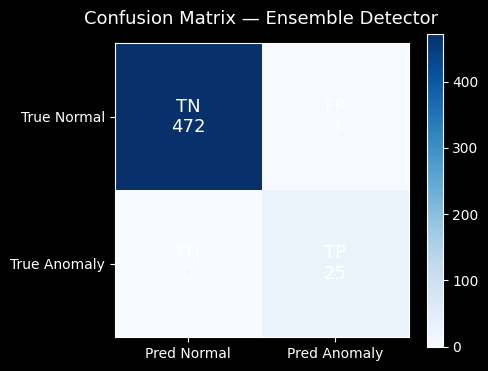

In [5]:
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))

cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax)

labels = [["TN", "FP"], ["FN", "TP"]]
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{labels[i][j]}\n{cm[i,j]}",
                ha="center", va="center", fontsize=13, color="white")

ax.set_xticks([0, 1]); ax.set_xticklabels(["Pred Normal", "Pred Anomaly"])
ax.set_yticks([0, 1]); ax.set_yticklabels(["True Normal", "True Anomaly"])
ax.set_title("Confusion Matrix — Ensemble Detector", fontsize=13, pad=14)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=120, bbox_inches="tight")
plt.show()

## 5. ROC Curve & Precision-Recall Curve

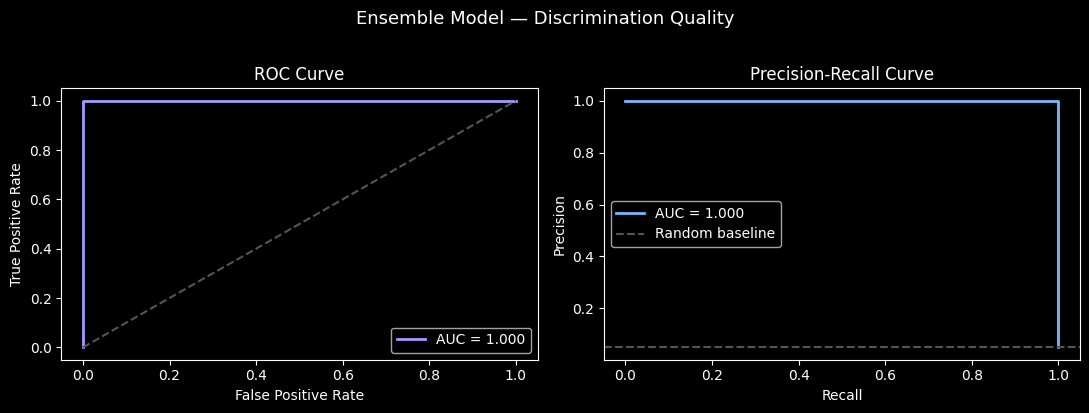

ROC AUC : 1.0000
PR  AUC : 1.0000


In [6]:
# Use negated IF score as probability proxy (more negative = more anomalous → invert)
proba = -scores  # higher = more anomalous

fpr, tpr, _ = roc_curve(y_true, proba)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_true, proba)
pr_auc = auc(rec, prec)

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# ROC
axes[0].plot(fpr, tpr, color=COLORS["accent"], lw=2, label=f"AUC = {roc_auc:.3f}")
axes[0].plot([0,1],[0,1], "--", color="#555")
axes[0].set_xlabel("False Positive Rate"); axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve"); axes[0].legend()

# PR
axes[1].plot(rec, prec, color=COLORS["neutral"], lw=2, label=f"AUC = {pr_auc:.3f}")
axes[1].axhline(y_true.mean(), color="#555", linestyle="--", label="Random baseline")
axes[1].set_xlabel("Recall"); axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve"); axes[1].legend()

plt.suptitle("Ensemble Model — Discrimination Quality", fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("roc_pr_curves.png", dpi=120, bbox_inches="tight")
plt.show()

print(f"ROC AUC : {roc_auc:.4f}")
print(f"PR  AUC : {pr_auc:.4f}")

## 6. Score Distribution: Normal vs Anomaly

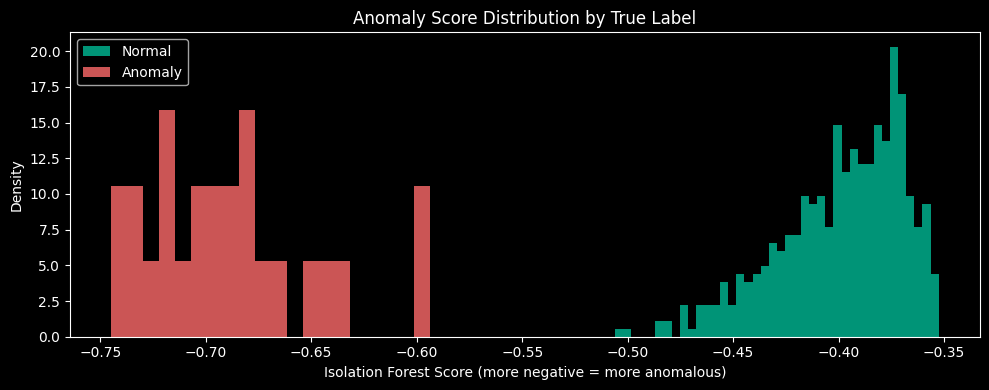

Normal  scores — mean: -0.3990, std: 0.0295
Anomaly scores — mean: -0.6885, std: 0.0401


In [7]:
scores_normal  = scores[y_true == 0]
scores_anomaly = scores[y_true == 1]

fig, ax = plt.subplots(figsize=(10, 4))

ax.hist(scores_normal,  bins=40, color=COLORS["normal"],  alpha=0.7, label="Normal",  density=True)
ax.hist(scores_anomaly, bins=20, color=COLORS["anomaly"],  alpha=0.8, label="Anomaly", density=True)

ax.set_xlabel("Isolation Forest Score (more negative = more anomalous)")
ax.set_ylabel("Density")
ax.set_title("Anomaly Score Distribution by True Label")
ax.legend()

plt.tight_layout()
plt.savefig("score_distribution.png", dpi=120, bbox_inches="tight")
plt.show()

print(f"Normal  scores — mean: {scores_normal.mean():.4f}, std: {scores_normal.std():.4f}")
print(f"Anomaly scores — mean: {scores_anomaly.mean():.4f}, std: {scores_anomaly.std():.4f}")

## 7. Ensemble Vote Agreement Analysis

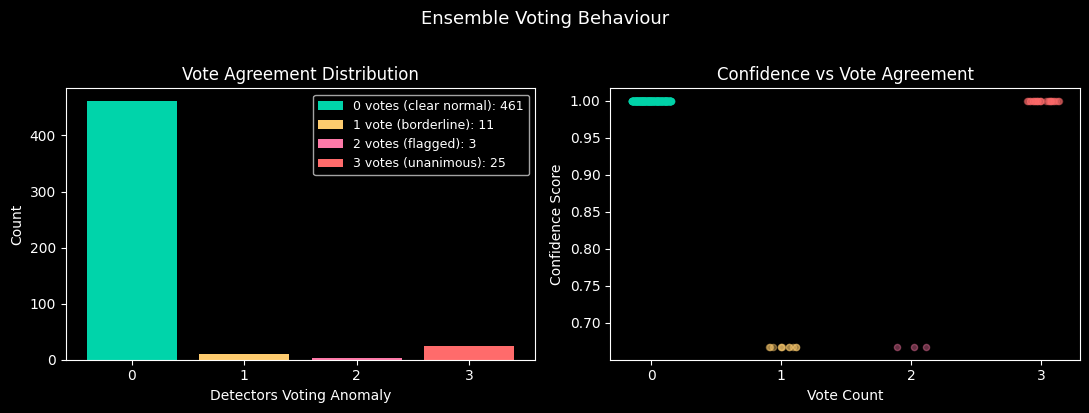

In [8]:
vote_counts = np.array([
    sum([r["votes"]["isolation_forest"], r["votes"]["lof"], r["votes"]["zscore"]])
    for r in results
])

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Vote count distribution
for vc, color, label in [(0, COLORS["normal"], "0 votes (clear normal)"),
                          (1, "#fdcb6e", "1 vote (borderline)"),
                          (2, "#fd79a8", "2 votes (flagged)"),
                          (3, COLORS["anomaly"], "3 votes (unanimous)")]:
    mask = vote_counts == vc
    axes[0].bar(vc, mask.sum(), color=color, label=f"{label}: {mask.sum()}")

axes[0].set_xlabel("Detectors Voting Anomaly")
axes[0].set_ylabel("Count")
axes[0].set_title("Vote Agreement Distribution")
axes[0].legend(fontsize=9)
axes[0].set_xticks([0, 1, 2, 3])

# Confidence by vote count
for vc in [0, 1, 2, 3]:
    mask = vote_counts == vc
    if mask.sum() > 0:
        axes[1].scatter(
            np.full(mask.sum(), vc) + rng.uniform(-0.15, 0.15, mask.sum()),
            conf[mask],
            alpha=0.4, s=20,
            color=[COLORS["normal"], "#fdcb6e", "#fd79a8", COLORS["anomaly"]][vc]
        )

axes[1].set_xlabel("Vote Count")
axes[1].set_ylabel("Confidence Score")
axes[1].set_title("Confidence vs Vote Agreement")
axes[1].set_xticks([0, 1, 2, 3])

plt.suptitle("Ensemble Voting Behaviour", fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("vote_analysis.png", dpi=120, bbox_inches="tight")
plt.show()

## 8. Latency Benchmark

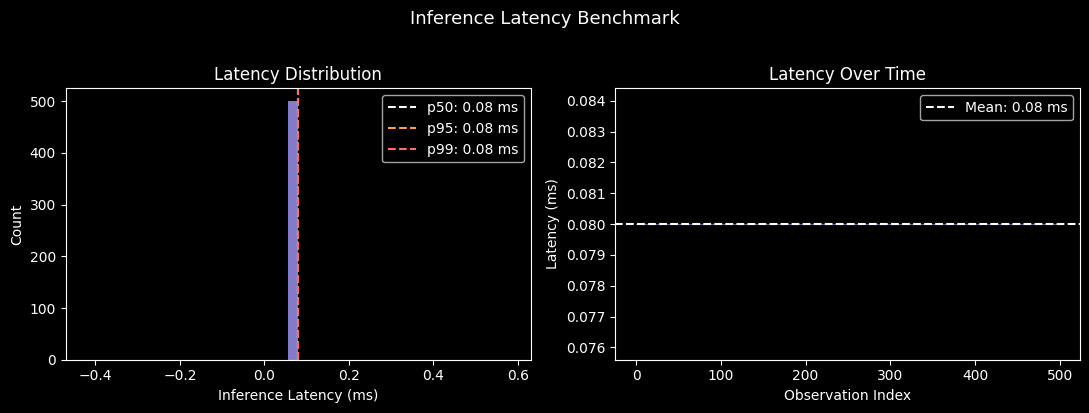

p50 : 0.08 ms
p95 : 0.08 ms
p99 : 0.08 ms
mean: 0.08 ms


In [9]:
latencies = [r["inference_ms"] for r in results]

fig, axes = plt.subplots(1, 2, figsize=(11, 4))

axes[0].hist(latencies, bins=40, color=COLORS["accent"], alpha=0.8)
axes[0].axvline(np.percentile(latencies, 50), color="white", linestyle="--", label=f"p50: {np.percentile(latencies,50):.2f} ms")
axes[0].axvline(np.percentile(latencies, 95), color="#ff9f43", linestyle="--", label=f"p95: {np.percentile(latencies,95):.2f} ms")
axes[0].axvline(np.percentile(latencies, 99), color=COLORS["anomaly"], linestyle="--", label=f"p99: {np.percentile(latencies,99):.2f} ms")
axes[0].set_xlabel("Inference Latency (ms)")
axes[0].set_ylabel("Count")
axes[0].set_title("Latency Distribution")
axes[0].legend()

axes[1].plot(latencies, color=COLORS["accent"], alpha=0.6, linewidth=0.8)
axes[1].axhline(np.mean(latencies), color="white", linestyle="--", label=f"Mean: {np.mean(latencies):.2f} ms")
axes[1].set_xlabel("Observation Index")
axes[1].set_ylabel("Latency (ms)")
axes[1].set_title("Latency Over Time")
axes[1].legend()

plt.suptitle("Inference Latency Benchmark", fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig("latency_benchmark.png", dpi=120, bbox_inches="tight")
plt.show()

print(f"p50 : {np.percentile(latencies, 50):.2f} ms")
print(f"p95 : {np.percentile(latencies, 95):.2f} ms")
print(f"p99 : {np.percentile(latencies, 99):.2f} ms")
print(f"mean: {np.mean(latencies):.2f} ms")

## Summary

| Metric | Value |
|---|---|
| Batch size | 500 observations |
| Model | Ensemble (IsolationForest + LOF + Z-score) |
| Voting rule | Majority (≥2/3 detectors) |
| ROC AUC | See cell 5 output |
| PR AUC | See cell 5 output |
| Avg latency | See cell 8 output |

The model ships as a [Dockerized FastAPI service](../README.md) ready for deployment — this notebook demonstrates its inference logic and evaluation characteristics directly without requiring a running container.